# Riparian vegetation WEP in response to grazing

Alex Koiter

## Load Libraries

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

This is DHARMa 0.4.7. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'

Loading required package: viridisLite

## Read in data

In [ ]:
conc <- read_csv(here::here("./notebooks/P_concentration.csv"))

Rows: 1141 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_type, timing, plot, location, treatment
dbl (3): site, ak_content, year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 576 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_type, timing, plot, location, treatment
dbl (3): site, dryweight, year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Merge data

In [ ]:
veg_data <- mass_data %>%
  right_join(conc) %>%
  rename(conc = ak_content) %>% # mg/kg
  mutate(p_total = conc * dryweight/1000 /0.25) # mg/m2

Joining with `by = join_by(sample_type, site, timing, plot, location, year,
treatment)`

## Biomass data

In [ ]:
biomass_diff <- veg_data %>%
  filter(sample_type == "Biomass") %>%
  mutate(dryweight = dryweight/1000 /0.25) %>% # kg/m2
  pivot_longer(cols = c(dryweight, p_total, conc), names_to = "measure", values_to = "value") %>%
  pivot_wider(names_from = timing, values_from = value) %>%
  mutate(diff = Before - After)

## Biomass Analysis

### P-total

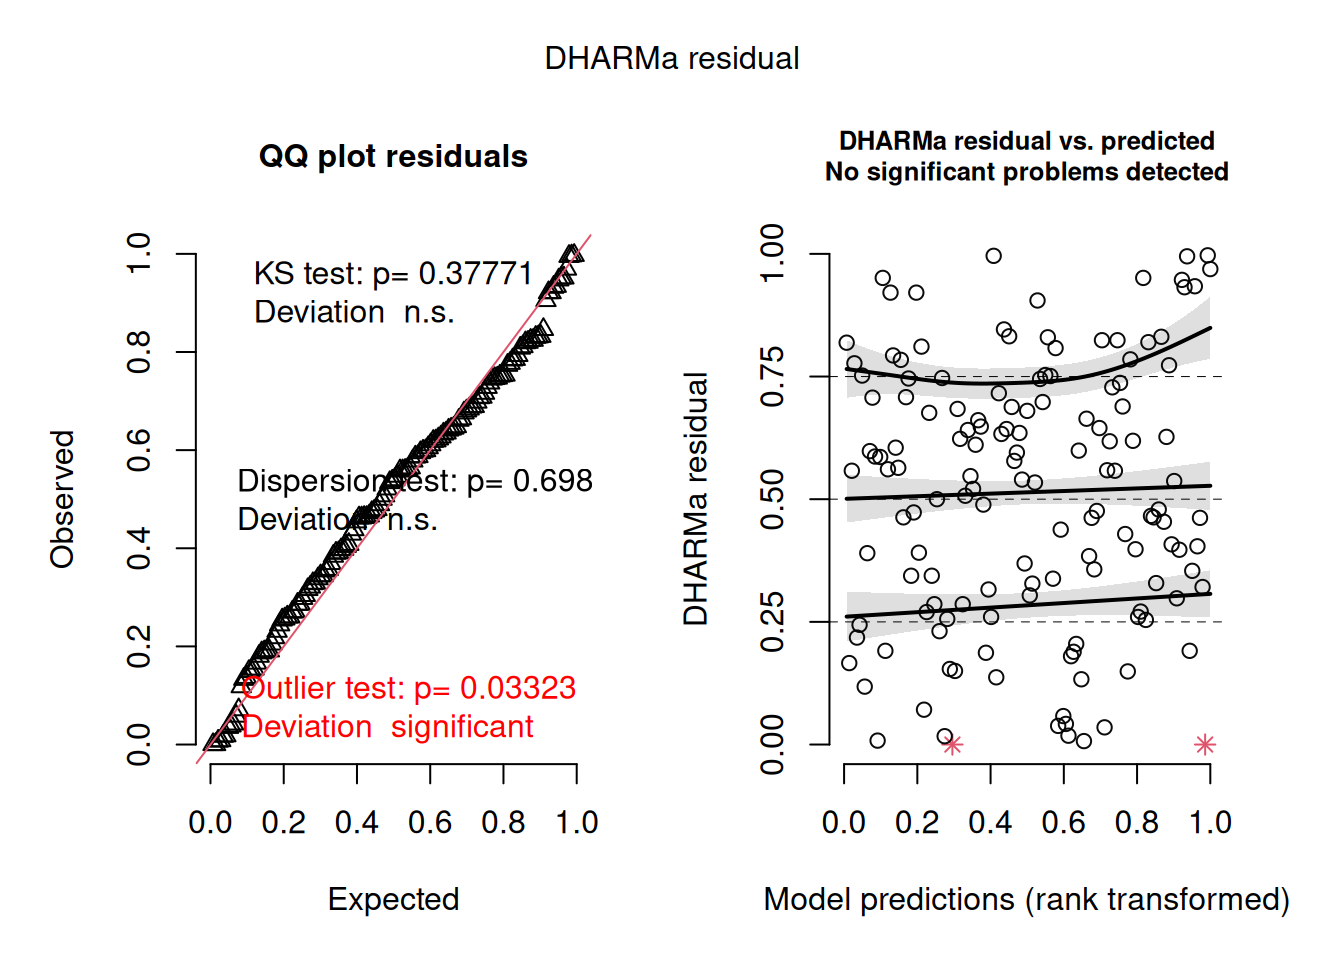

Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.751 0.611 0.716 0.648 0.463 0.707 0.684 0.558 0.811 0.623 0.328 0.664 0.676 0.595 0.785 0.304 0.68 0.547 0.369 0.329 ...

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: (diff)
                      Chisq Df Pr(>Chisq)    
(Intercept)         22.1909  1  2.468e-06 ***
treatment           15.4435  3   0.001474 ** 
location             9.0047  2   0.011083 *  
Before             178.7862  1  < 2.2e-16 ***
treatment:location   6.3738  6   0.382650    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [ ]:
m <- glmmTMB((diff) ~ treatment * location + Before + (1|site) + (1|year),
             data = filter(biomass_diff, measure == "p_total"))
simulateResiduals(m, n = 1000, plot = TRUE) 

Removing interaction

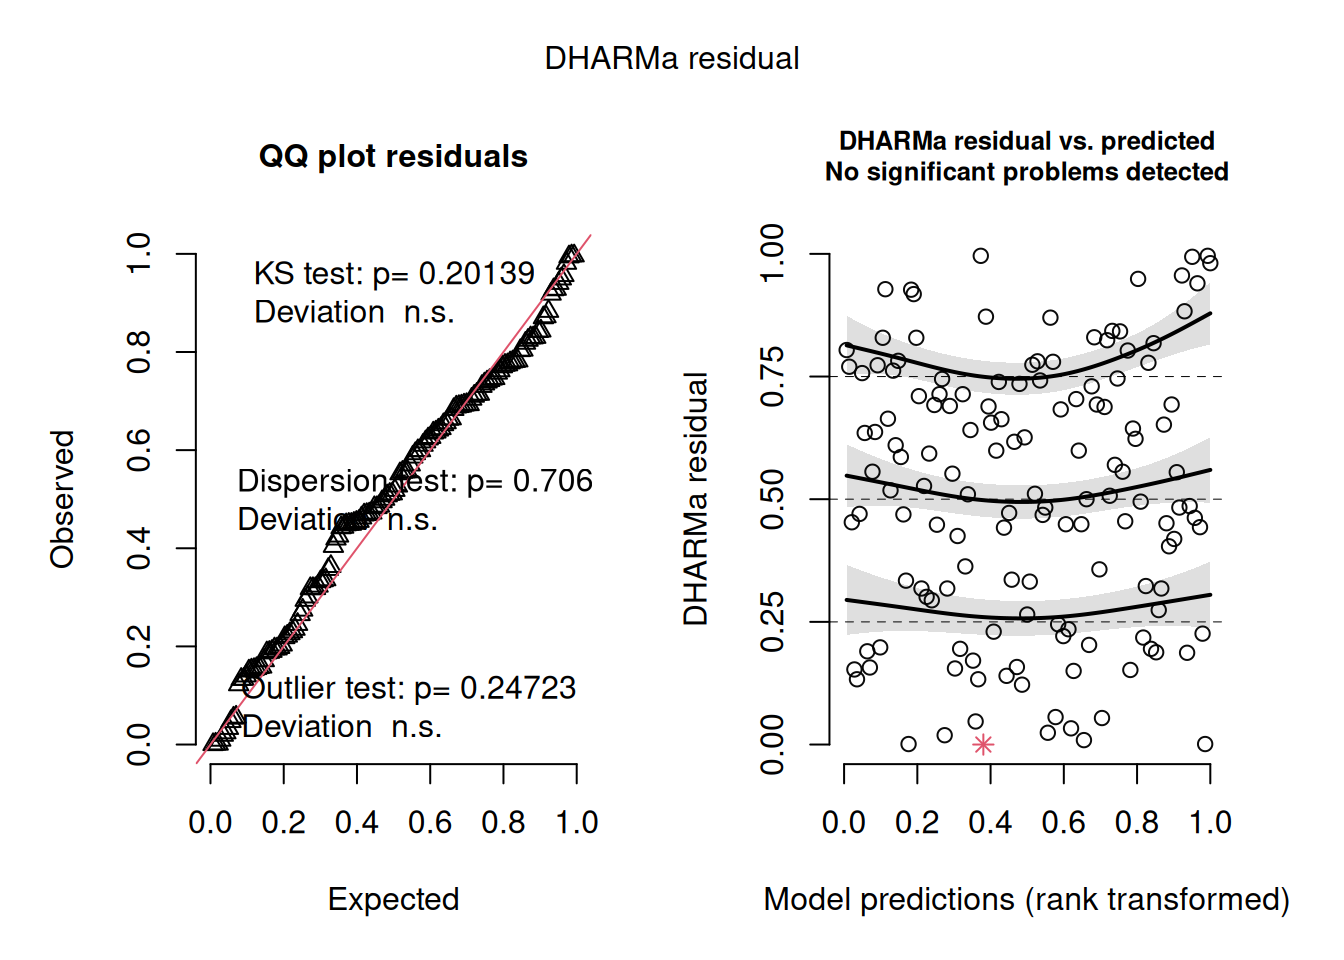

Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.781 0.692 0.617 0.69 0.469 0.664 0.714 0.47 0.829 0.472 0.332 0.78 0.71 0.511 0.803 0.336 0.739 0.442 0.245 0.323 ...

# Check for Multicollinearity

Low Correlation

      Term  VIF       VIF 95% CI Increased SE Tolerance Tolerance 95% CI
 treatment 1.00 [1.00, 2.67e+11]         1.00      1.00     [0.00, 1.00]
  location 1.59 [1.33,     2.03]         1.26      0.63     [0.49, 0.75]
    Before 1.59 [1.34,     2.04]         1.26      0.63     [0.49, 0.75]

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: (diff)
              Chisq Df Pr(>Chisq)    
(Intercept)  24.370  1  7.949e-07 ***
treatment    24.771  3  1.724e-05 ***
location     15.741  2  0.0003818 ***
Before      176.833  1  < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [ ]:
temp <- filter(biomass_diff, measure == "p_total") ## otherwise issue with emmeans()
m <- glmmTMB((diff) ~ treatment + location + Before + (1|site) + (1|year),
             data = temp)
simulateResiduals(m, n = 1000, plot = TRUE)

Post-hoc

In [ ]:
m_emms1 <- emmeans(m, ~treatment)
m_emms2 <- emmeans(m, ~location)

treat_pair <- summary(pairs(m_emms1, adjust = "fdr")) %>%
  mutate(type = "Treatment")
location_pair <- summary(pairs(m_emms2, adjust = "fdr")) %>%
  mutate(type = "Location")

pairs <- treat_pair %>%
  bind_rows(location_pair) %>%
  rename("Contrast" = "contrast", "Estimate" = "estimate", "t ratio" = "t.ratio", "p value" = "p.value")

In [ ]:
#| label: tbl-biomass-posthoc
#| tbl-cap: Results of the post-hoc pairwise comparisons with a Benjamini-Hochberg p value adjustment for differences in the net biomass WEP ($mg~m^{-2}$) between the four treatments and three riparian sampling locations.

pairs |>
  mutate(Contrast = fct_recode(Contrast, "Control - Graze" = "Control - Regular Graze", "High Graze - Graze" = "High Graze - Regular Graze", "Mow - Graze" = "Mow - Regular Graze")) |>
  group_by(type) |>
  gt() |>
  fmt_number(columns = c("Estimate", "SE", "t ratio"), decimal = 2)|>
  fmt_number(columns = c("p value"), decimal = 3)|>
  sub_small_vals(threshold = 0.001) |>
  tab_style(style =  cell_text(weight = "bold", align = "center"), locations =  cells_row_groups()) |>
  tab_options(column_labels.font.weight = "bold")

Contrast 
 Estimate 
 SE 
 df 
 t ratio 
 p value 
 
 
 
 
 Treatment 
 
 Control - High Graze 
 −4.83 
 2.42 
 132 
 −2.00 
 0.072 
 Control - Mow 
 −8.52 
 2.42 
 132 
 −3.52 
 0.002 
 Control - Graze 
 2.47 
 2.40 
 132 
 1.03 
 0.306 
 High Graze - Mow 
 −3.69 
 2.43 
 132 
 −1.51 
 0.159 
 High Graze - Graze 
 7.30 
 2.42 
 132 
 3.02 
 0.006 
 Mow - Graze 
 10.99 
 2.42 
 132 
 4.55 
 <0.001 
 
 Location 
 
 Lower - Middle 
 −7.94 
 2.43 
 132 
 −3.26 
 0.002 
 Lower - Upper 
 −9.82 
 2.57 
 132 
 −3.83 
 <0.001 
 Middle - Upper 
 −1.87 
 2.11 
 132 
 −0.89 
 0.377

### Summary

In [ ]:
biomass_diff %>%
  filter(measure == "p_total") %>%
  group_by(treatment) %>%
  summarise(median = median(diff, na.rm =T),
            mean = mean(diff, na.rm =T))

# A tibble: 4 × 3
  treatment     median  mean
  <chr>          <dbl> <dbl>
1 Control         5.50 12.1 
2 High Graze     10.4  16.3 
3 Mow            18.7  19.5 
4 Regular Graze   7.79  7.64

# A tibble: 3 × 3
  location median  mean
  <chr>     <dbl> <dbl>
1 Lower     17.5  20.1 
2 Middle     8.95 11.4 
3 Upper      6.23  9.89

### Plotting

Ordering of factors

In [ ]:
plot_data <- biomass_diff %>% 
  mutate(treatment = fct_recode(treatment, "Graze" = "Regular Graze")) %>%
  mutate(treatment = fct_relevel(treatment, c("Control", "Graze", "High Graze", "Mow"))) %>%
  mutate(location = fct_relevel(location, c("Upper", "Middle", "Lower")))

Extra

In [ ]:
df <- data.frame(x1 = c(-Inf, -Inf), x2 = c(Inf, Inf), y2 = c(Inf, 0), y1 = c(0, -Inf), difference = c("Net removal", "Net addition")) %>%
  mutate(difference = fct_relevel(difference, c("Net removal", "Net addition"))) 

Plots

(`stat_boxplot()`).

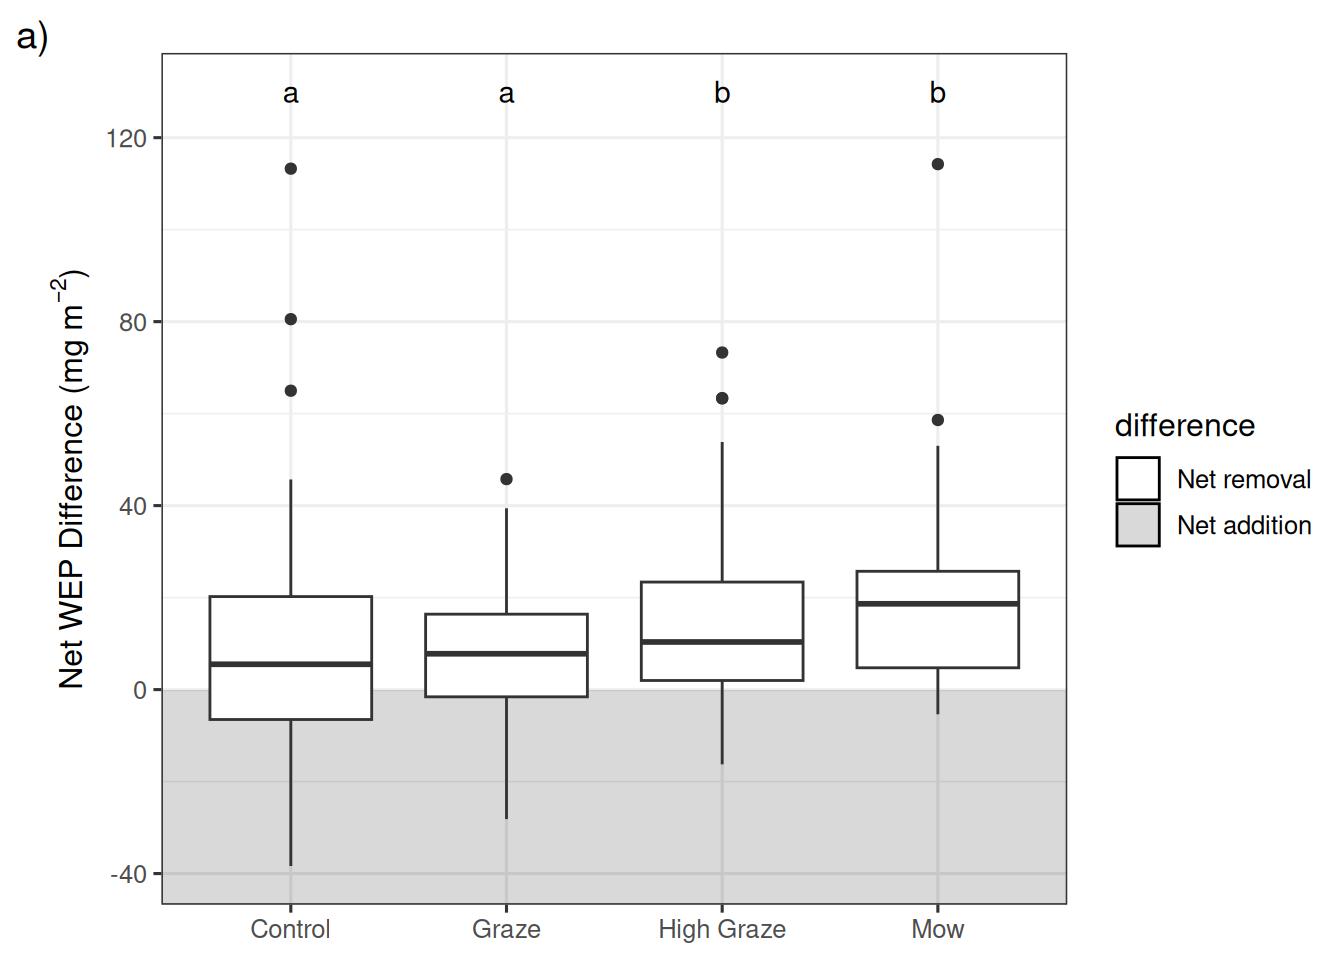

(`stat_boxplot()`).

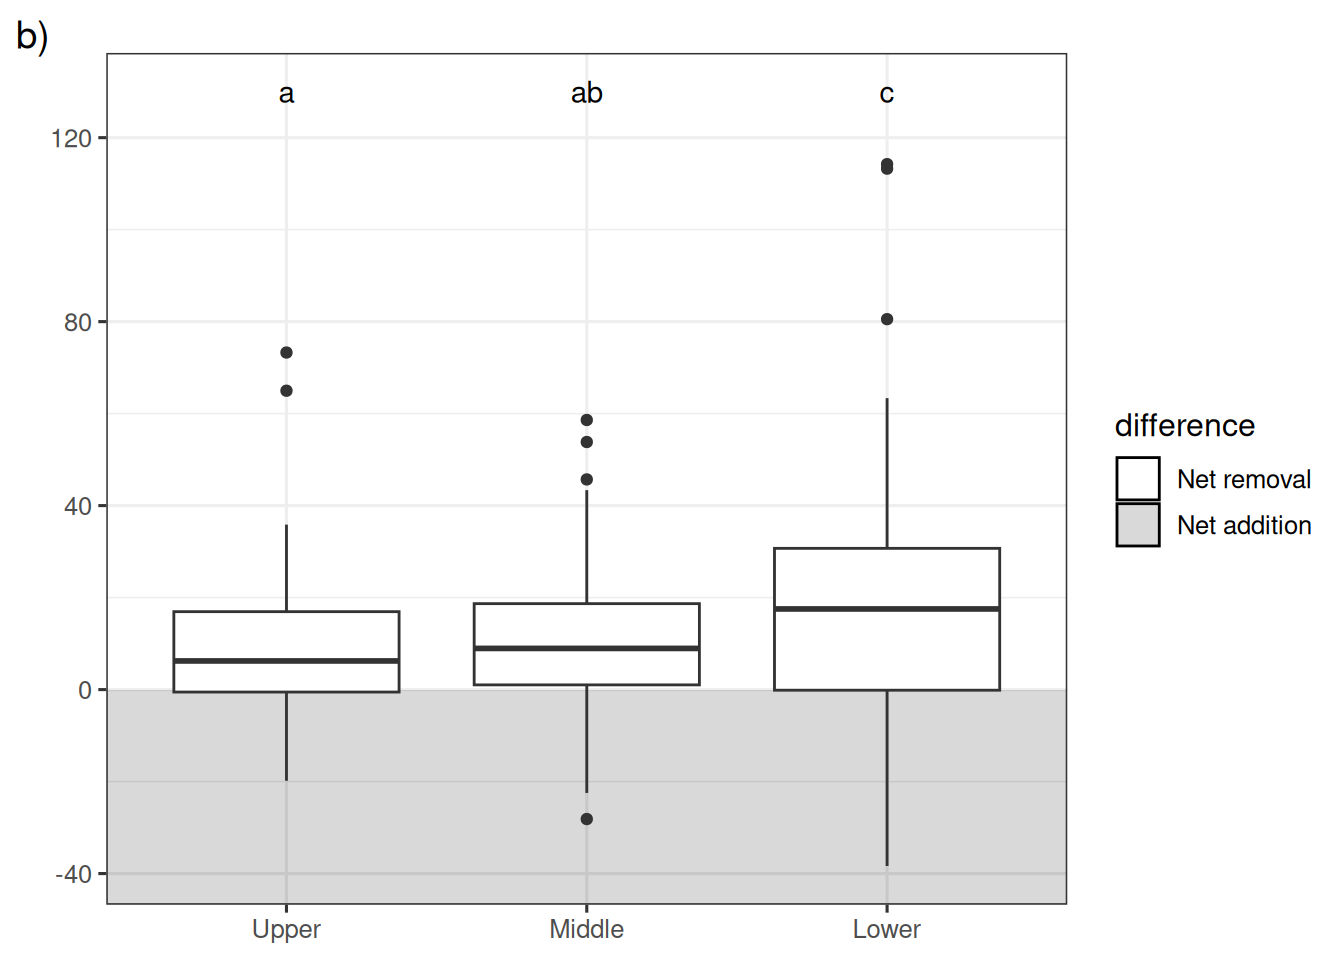

In [ ]:
p1 <- ggplot(data = filter(plot_data, measure == "p_total")) +
  geom_rect(data = df, aes(xmin = x1, xmax = x2, ymin = y1, ymax = y2, fill = difference), alpha = 0.15) +
  #geom_hline(yintercept = 0) +
  scale_y_continuous(breaks = seq(-40, 120, 40)) +
  geom_boxplot(data = filter(plot_data, measure == "p_total"), aes(x = treatment, y = diff)) +
  theme_bw(base_size = 12) + 
  labs(y = expression(paste("Net WEP Difference (", mg~m^{-2}, ")")), x = "Treatment", tag = "a)") +
  annotate("text", x = "Control", y = 130, label = "a") + 
  annotate("text", x = "Graze", y = 130, label = "a") + 
  annotate("text", x = "High Graze", y = 130, label = "b") + 
  annotate("text", x = "Mow", y = 130, label = "b") +
  scale_fill_manual(values = c("white", "black"), guide = guide_legend(override.aes = list(colour = "black"))) +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 0, vjust = 1, hjust = 0.5))
p1

(`stat_boxplot()`).
Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).

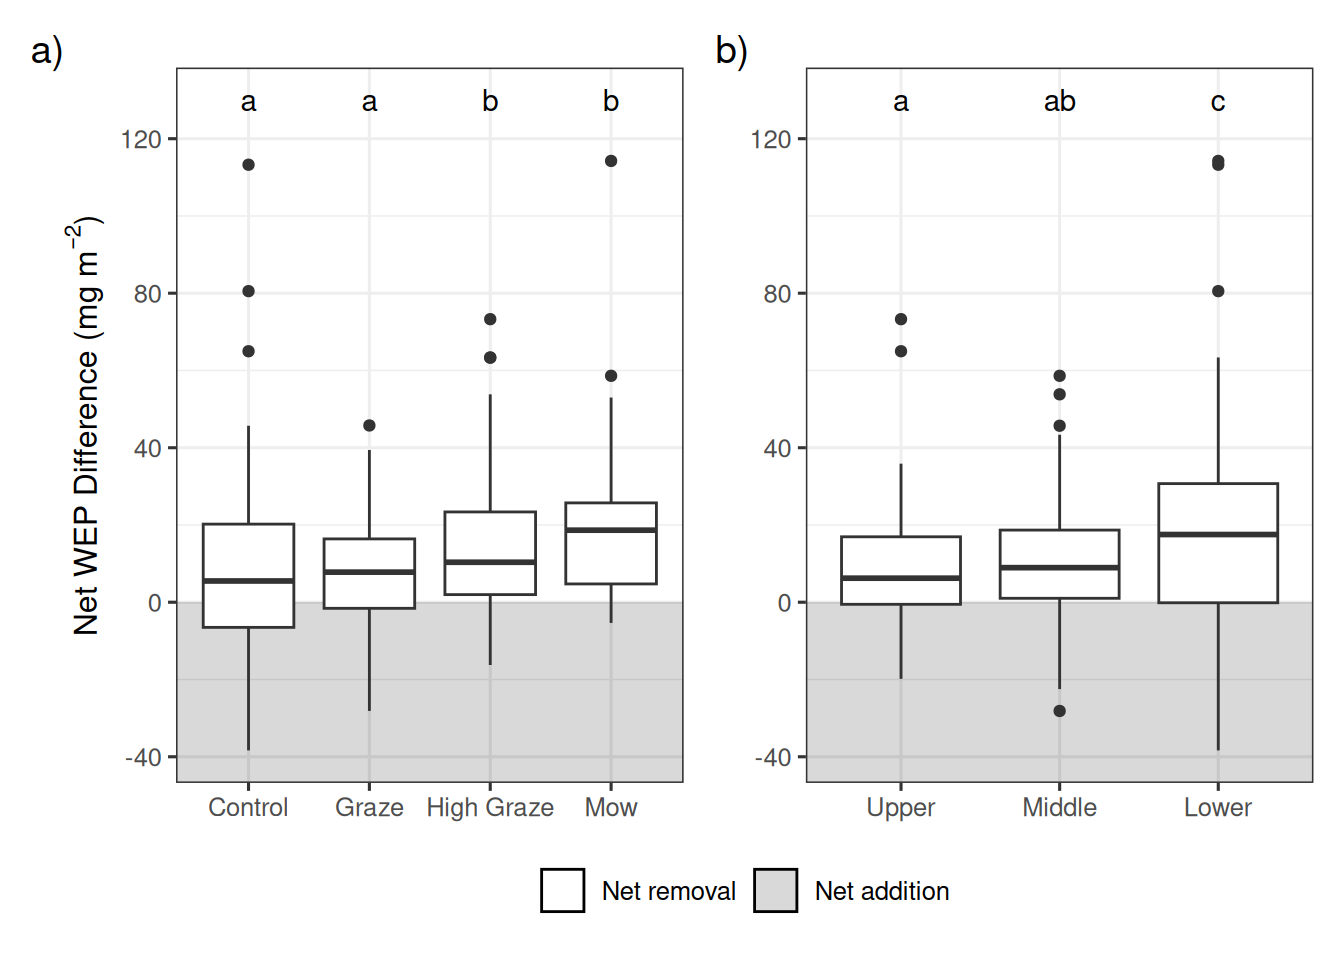

In [ ]:
#| label: fig-vegetation-WEP
#| fig-cap: "Change in riparian biomass WEP following grazing or mowing in each riparian location. Within each plot significant differences (p<0.05) between treatments or riparian locations are denoted with different letters. Lower sampling locations are adjacent to the edge of the waterbody and Upper locations are adjacent to the field."
#| fig-alt: "Boxplots showing the change in riparian biomass WEP following grazing or mowing."
#|   
p3 <- p1 + p2 + plot_layout(guides = 'collect') & theme(legend.position = 'bottom', legend.title = element_blank())
p3

## Dry Weight

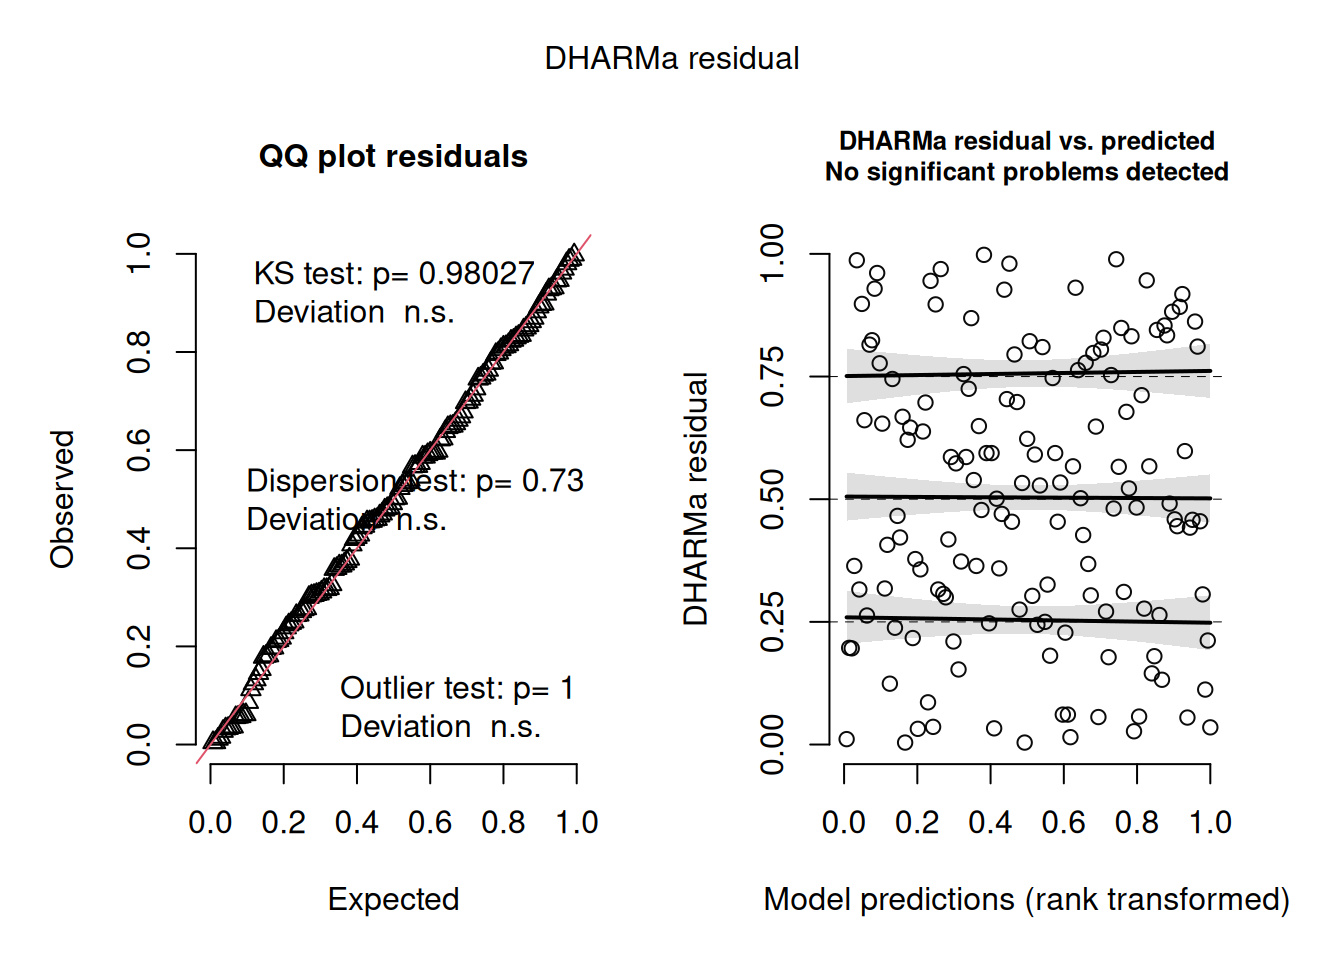

Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.854 0.648 0.326 0.646 0.318 0.725 0.668 0.466 0.81 0.586 0.427 0.882 0.777 0.897 0.805 0.368 0.704 0.594 0.586 0.522 ...

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: (diff)
                    Chisq Df Pr(>Chisq)    
(Intercept)        26.264  1  2.978e-07 ***
treatment          14.420  3   0.002385 ** 
location           10.771  2   0.004581 ** 
Before             76.432  1  < 2.2e-16 ***
treatment:location 13.564  6   0.034909 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

# Check for Multicollinearity

Low Correlation

      Term  VIF   VIF 95% CI Increased SE Tolerance Tolerance 95% CI
 treatment 1.04 [1.00, 2.88]         1.02      0.96     [0.35, 1.00]
  location 1.77 [1.47, 2.27]         1.33      0.57     [0.44, 0.68]
    Before 1.81 [1.50, 2.32]         1.35      0.55     [0.43, 0.67]

In [ ]:
m2 <- glmmTMB((diff) ~ treatment * location + Before + (1|site) + (1|year),
              data = filter(biomass_diff, measure == "dryweight"))
simulateResiduals(m2, n = 1000, plot = TRUE)

Post-hoc

In [ ]:
m_emms2 <- emmeans(m2, ~treatment * location)
emmeans(m2, pairwise ~ location|treatment, adjust = "fdr")$contrasts

treatment = Control:
 contrast       estimate     SE  df t.ratio p.value
 Lower - Middle -0.03993 0.0395 128  -1.011  0.3138
 Lower - Upper  -0.12232 0.0389 128  -3.147  0.0062
 Middle - Upper -0.08239 0.0365 128  -2.257  0.0386

treatment = High Graze:
 contrast       estimate     SE  df t.ratio p.value
 Lower - Middle -0.12667 0.0382 128  -3.315  0.0018
 Lower - Upper  -0.14328 0.0383 128  -3.744  0.0008
 Middle - Upper -0.01661 0.0365 128  -0.456  0.6495

treatment = Mow:
 contrast       estimate     SE  df t.ratio p.value
 Lower - Middle -0.02560 0.0372 128  -0.689  0.7859
 Lower - Upper  -0.01067 0.0392 128  -0.272  0.7859
 Middle - Upper  0.01493 0.0372 128   0.401  0.7859

treatment = Regular Graze:
 contrast       estimate     SE  df t.ratio p.value
 Lower - Middle  0.00666 0.0411 128   0.162  0.8716
 Lower - Upper  -0.02837 0.0430 128  -0.660  0.7658
 Middle - Upper -0.03503 0.0367 128  -0.955  0.7658

Note: contrasts are still on the ( scale. Consider using
      regrid() if 

location = Lower:
 contrast                   estimate     SE  df t.ratio p.value
 Control - High Graze        -0.0674 0.0368 128  -1.829  0.1046
 Control - Mow               -0.1391 0.0368 128  -3.778  0.0014
 Control - Regular Graze     -0.0532 0.0368 128  -1.446  0.1808
 High Graze - Mow            -0.0717 0.0365 128  -1.966  0.1029
 High Graze - Regular Graze   0.0142 0.0378 128   0.375  0.7081
 Mow - Regular Graze          0.0859 0.0378 128   2.274  0.0740

location = Middle:
 contrast                   estimate     SE  df t.ratio p.value
 Control - High Graze        -0.1541 0.0365 128  -4.222  0.0003
 Control - Mow               -0.1248 0.0366 128  -3.410  0.0017
 Control - Regular Graze     -0.0066 0.0365 128  -0.181  0.8567
 High Graze - Mow             0.0294 0.0367 128   0.799  0.5107
 High Graze - Regular Graze   0.1475 0.0366 128   4.036  0.0003
 Mow - Regular Graze          0.1182 0.0365 128   3.235  0.0023

location = Upper:
 contrast                   estimate     SE  df

### Plots

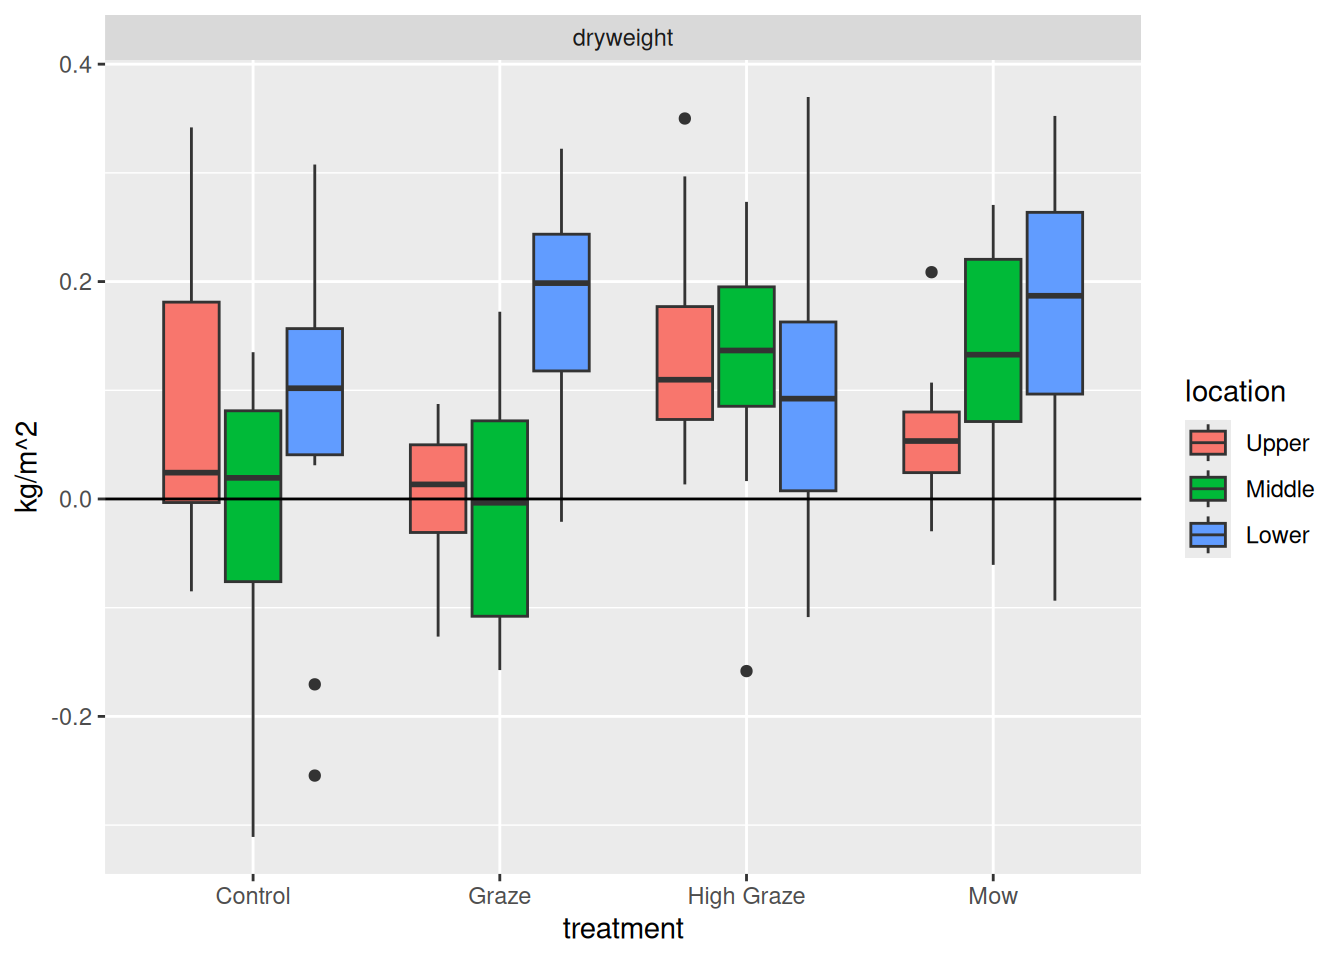

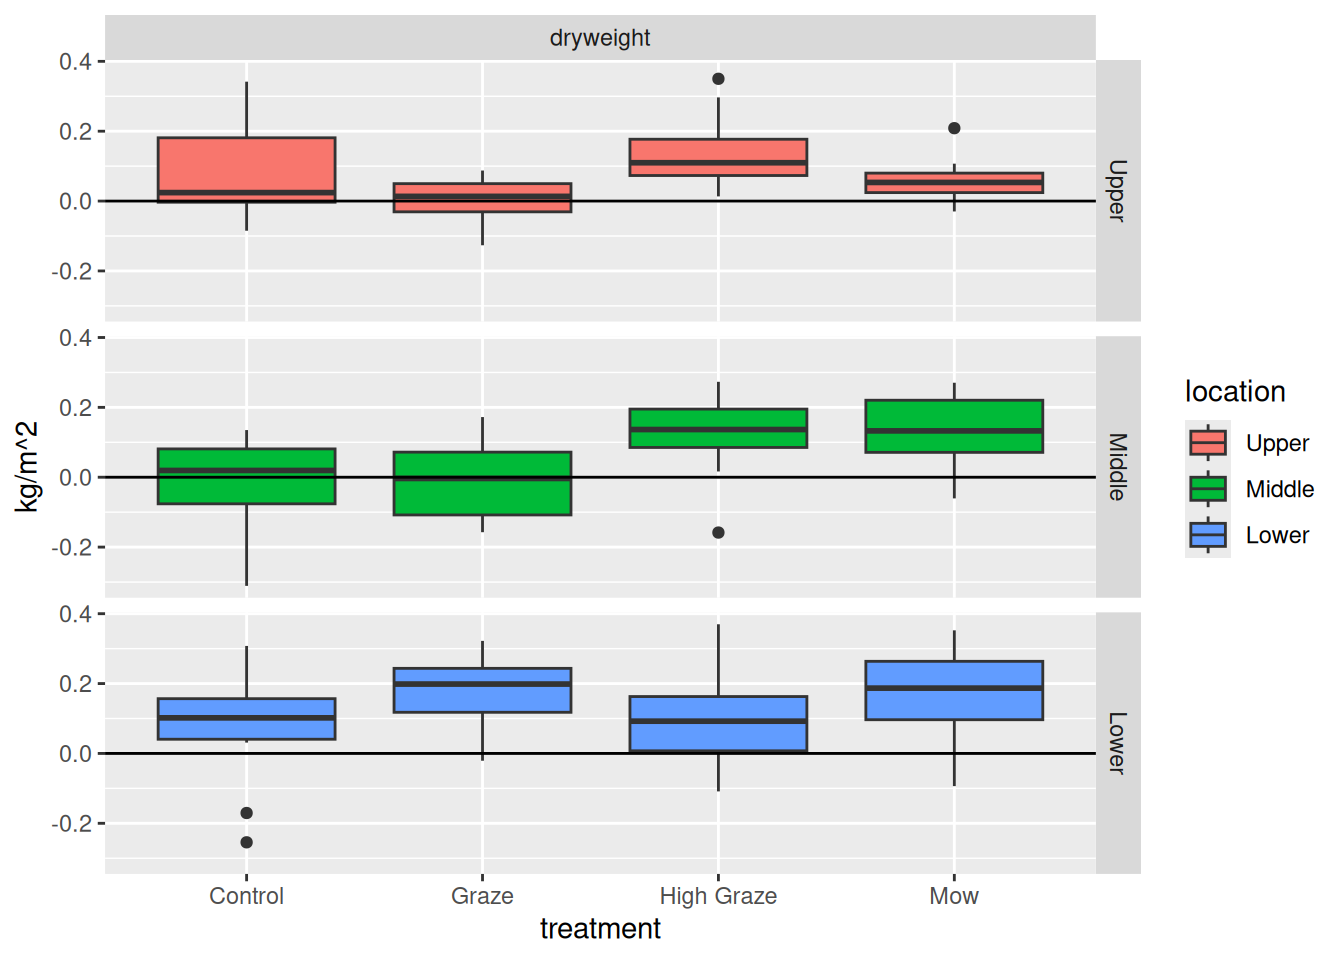

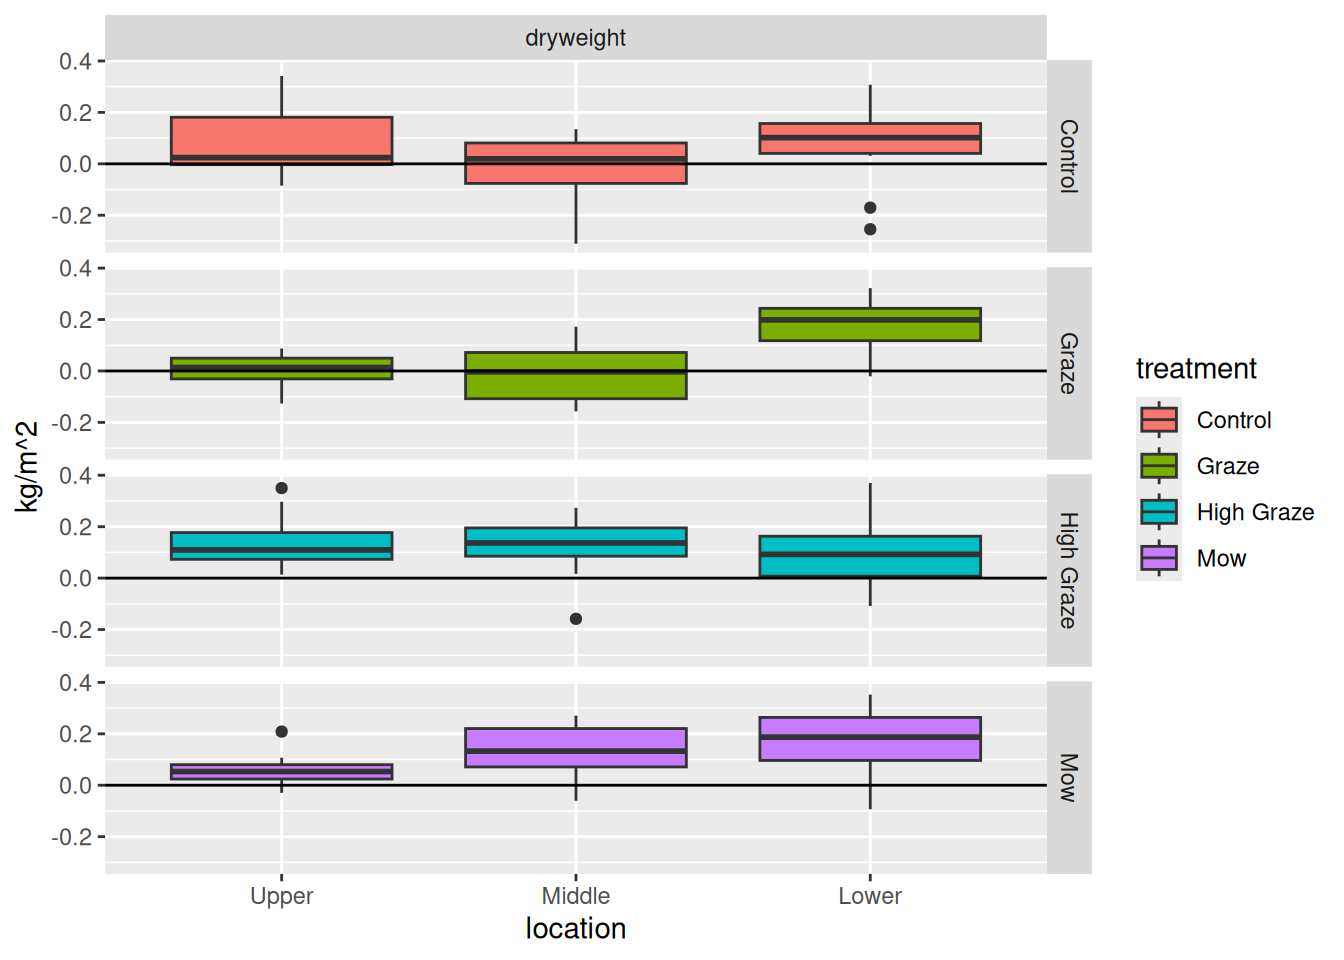

In [ ]:
ggplot(data = filter(plot_data, measure == "dryweight"), aes(x = treatment, y = diff, fill = location)) +
  geom_boxplot() +
  labs(y = "kg/m^2") +
  geom_hline(yintercept = 0) +
  facet_grid(~measure) 